In [ ]:
#default_exp attention

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import torch
from torch import nn, einsum
import torch.nn.functional as F
from fastai.basics import *

from functools import partial, reduce
from inspect import isfunction
from operator import mul
from copy import deepcopy

from torch import Tensor
from typing import Tuple

from einops import rearrange, repeat

from reformer_fastai.core import *
from reformer_fastai.layers import *

# Attention Modules 

In [ ]:
#export
MASK_VAL = -5e4
SELF_ATTN_MASK_VAL = -1e4

## Attention Projection

In [ ]:
#export
class AttnInProj(Module):
    """Computes q, k, v from input x and [optional] context"""
    def __init__(self, d_model:int, bias:bool=False):
        self.to_q = nn.Linear(d_model, d_model, bias=bias)
        self.to_k = nn.Linear(d_model, d_model, bias=bias)
        self.to_v = nn.Linear(d_model, d_model, bias=bias)
    def forward(self, x, context=None):
        context = ifnone(context, x)
        q = self.to_q(x)
        k, v = self.to_k(context), self.to_v(context)
        return q, k, v

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-16, d)
proj = AttnInProj(d)
q1, k1, v1 = proj(x)
assert (bs, sl, d) == q1.size() == k1.size() == v1.size()
q1.shape, k1.shape, v1.shape

(torch.Size([4, 128, 64]), torch.Size([4, 128, 64]), torch.Size([4, 128, 64]))

In [ ]:
q2, k2, v2 = proj(x, context)
assert (bs, sl, d) == q2.size()
assert k2.size() == v2.size() == context.size()
assert all_equal(q1, q2)
assert not all_equal(k1, k2)
q2.shape, k2.shape, v2.shape

(torch.Size([4, 128, 64]), torch.Size([4, 112, 64]), torch.Size([4, 112, 64]))

In [ ]:
#export
class AttnInProjV2(Module):
    """Computes q, k, v from input x and [optional] context"""
    def __init__(self, d_model:int, bias:bool=False):
        self.to_q = nn.Linear(d_model, d_model, bias=bias)
        self.to_kv = nn.Linear(d_model, 2*d_model, bias=bias)
    def forward(self, x, context=None):
        context = ifnone(context, x)
        q = self.to_q(x)
        k, v = self.to_kv(context).chunk(2, -1)
        return q, k, v

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-16, d)
proj = AttnInProj(d)
q1, k1, v1 = proj(x)
assert (bs, sl, d) == q1.size() == k1.size() == v1.size()
q1.shape, k1.shape, v1.shape

(torch.Size([4, 128, 64]), torch.Size([4, 128, 64]), torch.Size([4, 128, 64]))

In [ ]:
q2, k2, v2 = proj(x, context)
assert (bs, sl, d) == q2.size()
assert k2.size() == v2.size() == context.size()
assert all_equal(q1, q2)
assert not all_equal(k1, k2)
q2.shape, k2.shape, v2.shape

(torch.Size([4, 128, 64]), torch.Size([4, 112, 64]), torch.Size([4, 112, 64]))

## Shared Query-Key Attention Projection

In [ ]:
#export
class SharedQKAttnInProj(Module):
    """Computes q, k, v from input x and [optional] context"""
    def __init__(self, d_model:int, bias:bool=False):
        self.to_qk = nn.Linear(d_model, d_model, bias=bias)
        self.to_v = nn.Linear(d_model, d_model, bias=bias)
    def forward(self, x, context=None):
        context = ifnone(context, x)
        qk = self.to_qk(x)
        v = self.to_v(context)
        return qk, qk, v

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-16, d)
shared_proj = SharedQKAttnInProj(d)
q1, k1, v1 = shared_proj(x)
assert (bs, sl, d) == q1.size() == k1.size() == v1.size()
assert q1 is k1
q1.shape, k1.shape, v1.shape

(torch.Size([4, 128, 64]), torch.Size([4, 128, 64]), torch.Size([4, 128, 64]))

In [ ]:
#hide
#TODO: Figure out tests for when using SharedQKAttnInProj and context

## Scaled Dot Product Attention

In [ ]:
#export
#TODO make sure store_attention works
class ScaledDotProdAttention(Module):
    """
    Computes scaled dot-product attnetion given q, k, v
    """
    def __init__(self, d_model, n_heads, causal=False, dropout=0., shared_qk=False, store_attention:bool=False):
        store_attr()
        self.scale = (d_model//n_heads)**-0.5
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, q, k, v, input_mask=None):
        n, device = q.size(1), q.device
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.n_heads), (q, k, v))
        
        #TODO: remove after refactor confirmed working
        # boolean input_mask is False at positions not to attend to
#         input_mask = None
#         if any(map(exists, (mask, context_mask))):
#             q_mask = default(mask, lambda: torch.ones((b, n), device = device).bool())
#             k_mask = q_mask if not exists(context) else context_mask
#             k_mask = default(k_mask, lambda: torch.ones((b, k.shape[-2]), device = device).bool())
            
#             q_mask = rearrange(q_mask, 'b i -> b () i ()')
#             k_mask = rearrange(k_mask, 'b j -> b () () j')
#             input_mask = q_mask * k_mask
        
        # classic dot-product attention
        dots = torch.einsum('bhid,bhjd->bhij', q*self.scale, k)
        
        if exists(input_mask):
            dots.masked_fill_(~input_mask, MASK_VAL)
            del input_mask
            
        if self.shared_qk:
            b, h, i, j = dots.shape[:]
            m = torch.arange(i)
            self_mask = torch.zeros(b, h, i, j).bool()    
            self_mask[:, :, m, m] = True
            dots.masked_fill_(self_mask, SELF_ATTN_MASK_VAL)
            del self_mask

#         if self.causal:
#             i, j = dots.shape[-2:]
#             mask = torch.ones((i, j), device = device).triu_(j - i + 1).bool()
#             dots.masked_fill_(mask, MASK_VAL)
#             del mask
        if self.causal:
            i, j = torch.triu_indices(n, n, 1)
            dots[:,:,i,j] = MASK_VAL

        attn = F.softmax(dots, -1)
        if self.store_attention: self.attention = attn.detach().cpu()
        
        attn = self.dropout(attn)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return out

Scaled dot-product attention is calculated as:

$$\textbf {Attention}(Q,K,V) = \textbf {softmax}({QK^T\over\sqrt d_k})V $$

In [ ]:
q = torch.randn(bs, sl, d)
k = torch.randn(bs, sl, d)
v = torch.randn(bs, sl, d)
attn_func = ScaledDotProdAttention(d, 4)
out = attn_func(q, k, v)
out.shape

torch.Size([4, 128, 64])

In [ ]:
# Test shared_qk
attn_func = ScaledDotProdAttention(d, 4, shared_qk=True)
out = attn_func(q, k, v)
out.shape

torch.Size([4, 128, 64])

In [ ]:
#hide
#TODO: add tests with input mask

## Attention container

In [ ]:
#export
class Attention(Module):
    """
    Standard attention module using scaled dot-product attention
    """
    def __init__(self, 
                 d_model:int, 
                 n_heads:int = 8, 
                 causal:bool = False,
                 mask:Tensor = None,
                 dropout:float=0.1,
                 out_dropout:float=None,
                 bias:bool=False,
                 shared_qk:bool=False,
                 store_attention:bool=False):
        store_attr('causal, mask, n_heads, bias, shared_qk')
        out_dropout = ifnone(out_dropout, dropout)
        if shared_qk: self.in_proj = SharedQKAttnInProj(d_model, bias=bias)
        else: self.in_proj = AttnInProjV2(d_model, bias=bias)
        self.attn = ScaledDotProdAttention(d_model, n_heads, causal=causal,
                                           dropout=dropout, shared_qk=shared_qk, 
                                           store_attention=store_attention)
        self.out_proj = nn.Linear(d_model, d_model, bias=bias)
        self.dropout = nn.Dropout(out_dropout)
        self._init()

    def forward(self, x, context = None, mask = None, context_mask = None):
        q, k, v = self.in_proj(x, context)
        if self.shared_qk: k = F.normalize(k, 2, dim=-1).type_as(k)
                
        input_mask = self._make_input_mask(mask, context_mask, x, context)
        out = self.attn(q, k, v, input_mask)
        
        out = self.out_proj(out)
        return self.dropout(out)
        
    def _init(self):
        [nn.init.xavier_uniform_(w) for w in self.parameters() if w.dim()>1]
        if self.bias:
            [nn.init.constant_(b, 0) for b in self.parameters() if b.dim()==1]
    
    def _make_input_mask(self, mask, context_mask, x, context):
        if any(map(exists, (mask, context_mask))):
            b, n, _, device = *x.size(), x.device
            q_mask = default(mask, lambda: torch.ones((b, n), device = device).bool())
            k_mask = q_mask if not exists(context) else context_mask
            k_mask = default(k_mask, lambda: torch.ones((b, context.shape[-2]), device = device).bool())
            
            q_mask = rearrange(q_mask, 'b i -> b () i ()')
            k_mask = rearrange(k_mask, 'b j -> b () () j')
            return q_mask * k_mask
        else: return None #input_mask is None if both mask and context_mask are None

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-16, d)
attn = Attention(d)
out = attn(x)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 64])

In [ ]:
out = attn(x, context)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 64])

In [ ]:
# test shared_qk
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-16, d)
attn = Attention(d, shared_qk=True)
out = attn(x)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 64])

In [ ]:
e_msg = "Causal masking error"
attn = Attention(d, causal=True, dropout=0)
x1 = torch.randn(bs, sl, d)
out1 = attn(x1)
x2 = x1.clone()
x2[:, sl//2:, :] = torch.randn(bs, sl//2, d)
out2 = attn(x2)
# all elements in first half are equal despite second half is defferent
assert all_equal(out1[:, :sl//2], out2[:, :sl//2]), e_msg
assert not (out1[:, sl//2:] == out2[:, sl//2:]).any(), e_msg

In [ ]:
e_msg = "Masking error"
attn = Attention(d, causal=False, dropout=0)
x1 = torch.randn(bs, sl, d)
mask = torch.ones(bs, sl)
# mask out second half of input
mask[:, sl//2:] = 0
mask = mask.bool()
out1 = attn(x1, mask=mask)
x2 = x1.clone()
x2[:, sl//2:, :] = torch.randn(bs, sl//2, d)
out2 = attn(x2, mask=mask)
# all elements are equal, masked values do not effect result
assert all_equal(out1[:, :sl//2], out2[:, :sl//2]), e_msg
out1 = attn(x1)
out2 = attn(x2)
assert not (out1[:, :sl//2] == out2[:, :sl//2]).any()

In [ ]:
e_msg = "Context masking error"
attn = Attention(d, causal=False, dropout=0)
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl, d)
context_mask = torch.ones(bs, sl)
# mask out second half of context
context_mask[:, sl//2:] = 0
context_mask = context_mask.bool()
out1 = attn(x, context, context_mask=context_mask)
context2 = context.clone()
context2[:, sl//2:, :] = torch.randn(bs, sl//2, d)
out2 = attn(x, context2, context_mask=context_mask)
# all elements are equal, masked values do not effect result
assert all_equal(out1, out2), e_msg
# all output values are different for different context
out1 = attn(x, context)
out2 = attn(x, context2)
assert not (out1 == out2).any()

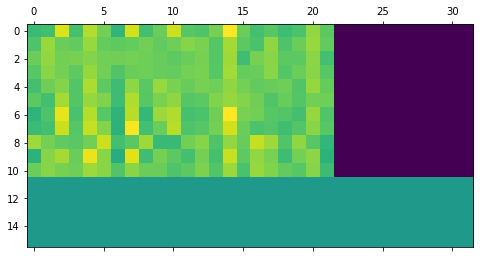

In [ ]:
# check stored attention matrix
bs = 4
sl = 16
csl = sl + 16
d = 64
x = torch.rand(bs, sl, d)
context = torch.rand(bs, csl, d)
mask = torch.ones(bs, sl)
mask[:, -5:] = 0
context_mask = torch.ones(bs, csl)
context_mask[:, -10:] = 0
mask, context_mask = mask.bool(), context_mask.bool()
attn = Attention(d, store_attention=True)
out = attn(x, context, mask=mask, context_mask=context_mask)
attention = attn.attn.attention
assert (bs, sl, d) == out.size()
assert attention.size() == (bs, attn.attn.n_heads, sl, csl)
# zeros for masked keys and "don't cares" for masked queries
plt.matshow(attention[0,0]);

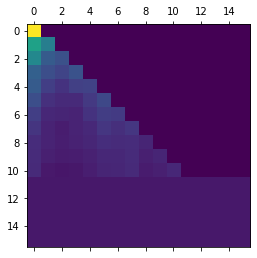

In [ ]:
#hide
#skip
# check stored attention matrix
bs = 4
sl = 16
d = 64
x = torch.rand(bs, sl, d)
mask = torch.ones(bs, sl)
mask[:, -5:] = 0
mask = mask.bool()
attn = Attention(d, store_attention=True, causal=True)
out = attn(x, mask=mask)
attention = attn.attn.attention
assert (bs, sl, d) == out.size()
assert attention.size() == (bs, attn.attn.n_heads, sl, sl)
# zeros for masked keys and "don't cares" for masked queries
plt.matshow(attention[0,0]);

## Additive Attention

In [ ]:
#hide
# previous version of additive attention for reference
class DecoderAttention(Module):
    def __init__(self, 
                 d_model, 
                 heads = 8, 
                 causal = False,
                 mask = None,
                 dropout=0.1, 
                 bias=False):
        self.causal = causal
        self.store_attention = False
        self.mask = mask #??
        self.heads = heads
        self.scale = (d_model//heads) ** -0.5
        
        self.to_q = nn.Linear(d_model, d_model, bias = bias)
        self.to_kv = nn.Linear(d_model, d_model * 2, bias = bias)
        self.dropout = nn.Dropout(dropout)

        self.to_out = nn.Linear(d_model, d_model)

        self._init()

    def forward(self, x, context = None, mask = None, context_mask = None, store_attention=False):
        b, n, d, h, device = *x.shape, self.heads, x.device
        context = default(context, torch.empty(b, 0, d, dtype=x.dtype, device=device))
        kv_input = torch.cat([x, context], dim=-2)
        
        q = self.to_q(x)
        kv = self.to_kv(kv_input).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, *kv))

        # boolean input_mask is False at positions not to attend to
        input_mask = None
        if any(map(exists, (mask, context_mask))):
            q_mask = default(mask, lambda: torch.ones((b, n), device = device).bool())
            self_mask = q_mask[:, None, :, None] * q_mask[:, None, None, :]
            if context.size(-2) != 0:
                k_mask = default(context_mask, lambda: torch.ones((b, context.shape[-2]), device = device).bool())
                cross_mask = q_mask[:, None, :, None] * k_mask[:, None, None, :]
            else: cross_mask = torch.empty(0, dtype=self_mask.dtype, device=device)
            input_mask = torch.cat([self_mask, cross_mask], dim=-1)
        
        # classic scaled dot-product attention
        dots = torch.einsum('bhid,bhjd->bhij', q * self.scale, k)
        
        # might need to tune MASK_VAL for fp16 to work
        if exists(input_mask):
            dots.masked_fill_(~input_mask, MASK_VAL)
            del input_mask

        if self.causal:
            i, j = torch.triu_indices(n, n, 1)
            dots[:,:,i,j] = MASK_VAL

        attn = F.softmax(dots, -1)
        if self.store_attention: # and not self.training
            self.attention = attn.detach().cpu()
        attn = self.dropout(attn)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

    def _init(self):
        [nn.init.xavier_uniform_(w) for w in [self.to_q.weight, self.to_kv.weight, self.to_out.weight]]
        if getattr(self.to_q, 'bias', None) is not None: nn.init.constant_(self.to_q.bias, 0)
        if getattr(self.to_kv, 'bias', None) is not None: nn.init.constant_(self.to_kv.bias, 0)
        nn.init.constant_(self.to_out.bias, 0)

In [ ]:
#export
class AdditiveInProj(Module):
    """Computes q, k, v from input x and [optional] context"""
    def __init__(self, d_model:int, bias:bool=False):
        self.to_q = nn.Linear(d_model, d_model, bias=bias)
        self.to_k = nn.Linear(d_model, d_model, bias=bias)
        self.to_v = nn.Linear(d_model, d_model, bias=bias)
    def forward(self, x, context=None):
        b, _, d = x.size()
        context = ifnone(context, torch.empty(b, 0, d, dtype=x.dtype, device=x.device))
        kv_input = torch.cat([x, context], dim=-2)
        q = self.to_q(x)
        k, v = self.to_k(kv_input), self.to_v(kv_input)
        return q, k, v

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-16, d)
proj = AdditiveInProj(d)
q1, k1, v1 = proj(x)
assert (bs, sl, d) == q1.size() == k1.size() == v1.size()
q1.shape, k1.shape, v1.shape

(torch.Size([4, 128, 64]), torch.Size([4, 128, 64]), torch.Size([4, 128, 64]))

In [ ]:
q2, k2, v2 = proj(x, context)
assert (bs, sl, d) == q2.size()
assert k2.size() == v2.size() == (bs, x.size(1)+context.size(1), d)
assert all_equal(q1, q2)
assert not all_equal(k1, k2)
q2.shape, k2.shape, v2.shape

(torch.Size([4, 128, 64]), torch.Size([4, 240, 64]), torch.Size([4, 240, 64]))

In [ ]:
#export
#TODO: add support for shared_qk for additive attn
class AdditiveAttention(Attention):
    """
    Additive attention module
    """
    def __init__(self, 
                 d_model:int, 
                 n_heads:int = 8, 
                 causal:bool = True,
                 dropout:float=0.1,
                 out_dropout:float=None,
                 bias:bool=False,
                 shared_qk:bool = False,
                 store_attention:bool=False):
        store_attr('causal, n_heads, bias, shared_qk')
        out_dropout = ifnone(out_dropout, dropout)
        self.in_proj = AdditiveInProj(d_model, bias=bias)
        self.attn = ScaledDotProdAttention(d_model, n_heads, causal=causal,
                                           dropout=dropout, store_attention=store_attention)
        self.out_proj = nn.Linear(d_model, d_model, bias=bias)
        self.dropout = nn.Dropout(out_dropout)
        self._init()
    
    def _make_input_mask(self, mask, context_mask, x, context):
        b, n, _, device = *x.size(), x.device
        if any(map(exists, (mask, context_mask))):
            q_mask = default(mask, lambda: torch.ones((b, n), device=device).bool())
            self_mask = q_mask[:, None, :, None] * q_mask[:, None, None, :]
            if exists(context):
                k_mask = default(context_mask, lambda: torch.ones((b, context.shape[-2]), device=device).bool())
                cross_mask = q_mask[:, None, :, None] * k_mask[:, None, None, :]
            else: cross_mask = torch.empty(0, dtype=self_mask.dtype, device=device)
            return torch.cat([self_mask, cross_mask], dim=-1)
        else: return None #input_mask is None if both mask and context_mask are None

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl-16, d)
attn = AdditiveAttention(d)
out = attn(x)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 64])

In [ ]:
#hide
#TODO: tests for additive attention

In [ ]:
out = attn(x, context)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 64])

In [ ]:
#hide
#TODO: add tests with input mask

In [ ]:
e_msg = "Causal masking error"
attn = AdditiveAttention(d, causal=True, dropout=0)
x1 = torch.randn(bs, sl, d)
out1 = attn(x1)
x2 = x1.clone()
x2[:, sl//2:, :] = torch.randn(bs, sl//2, d)
out2 = attn(x2)
# all elements in first half are equal despite second half is defferent
assert all_equal(out1[:, :sl//2], out2[:, :sl//2]), e_msg
assert not (out1[:, sl//2:] == out2[:, sl//2:]).any(), e_msg

In [ ]:
e_msg = "Masking error"
attn = AdditiveAttention(d, causal=False, dropout=0)
x1 = torch.randn(bs, sl, d)
mask = torch.ones(bs, sl)
# mask out second half of input
mask[:, sl//2:] = 0
mask = mask.bool()
out1 = attn(x1, mask=mask)
x2 = x1.clone()
x2[:, sl//2:, :] = torch.randn(bs, sl//2, d)
out2 = attn(x2, mask=mask)
# all elements are equal, masked values do not effect result
assert all_equal(out1[:, :sl//2], out2[:, :sl//2]), e_msg
out1 = attn(x1)
out2 = attn(x2)
assert not (out1[:, :sl//2] == out2[:, :sl//2]).any()

In [ ]:
e_msg = "Context masking error"
attn = Attention(d, causal=False, dropout=0)
x = torch.randn(bs, sl, d)
context = torch.randn(bs, sl, d)
context_mask = torch.ones(bs, sl)
# mask out second half of context
context_mask[:, sl//2:] = 0
context_mask = context_mask.bool()
out1 = attn(x, context, context_mask=context_mask)
context2 = context.clone()
context2[:, sl//2:, :] = torch.randn(bs, sl//2, d)
out2 = attn(x, context2, context_mask=context_mask)
# all elements are equal, masked values do not effect result
assert all_equal(out1, out2), e_msg
# all output values are different for different context
out1 = attn(x, context)
out2 = attn(x, context2)
assert not (out1 == out2).any()

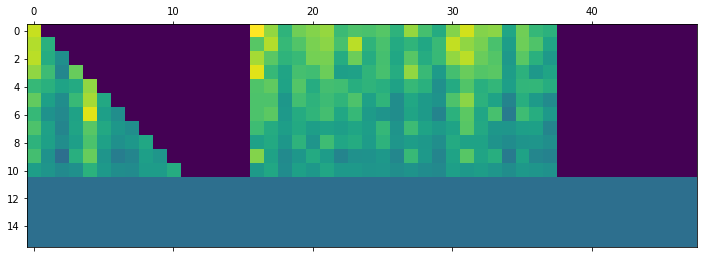

In [ ]:
#hide
#skip
# check stored attention matrix
bs = 4
sl = 16
csl = sl + 16
d = 64
x = torch.rand(bs, sl, d)
context = torch.rand(bs, csl, d)
mask = torch.ones(bs, sl)
mask[:, -5:] = 0
context_mask = torch.ones(bs, csl)
context_mask[:, -10:] = 0
mask, context_mask = mask.bool(), context_mask.bool()
attn = AdditiveAttention(d, store_attention=True)
out = attn(x, context, mask=mask, context_mask=context_mask)
attention = attn.attn.attention
# assert (bs, sl, d) == out.size()
# assert attention.size() == (bs, attn.attn.n_heads, sl, csl)
# zeros for masked keys and "don't cares" for masked queries
plt.matshow(attention[0,0]);

## LSH Attention

LSH attention from Reformer: [The Efficient Transformer](https://arxiv.org/abs/2001.04451). Based on [lucidrains/reformer-pytorch](https://github.com/lucidrains/reformer-pytorch/), but simpliefied and refactored. Uses shared keys and queries, but requires both to be passed as input (even though they are identical).

In [ ]:
#export
class LSHAttention(Module):
    """
    LSH attention module: 
    """
    def __init__( self,
                  dropout = 0.,                       # attention matrix dropout
                  bucket_size = 64,                   # at least 64 suggested in trax
                  n_hashes = 8,                       # papers sugests 8
                  causal = False,
                  allow_duplicate_attention = False,  # as in the paper
                  attend_across_buckets = False,      # as in the paper
                  drop_for_hash_rate = 0.0,           # unsure of default, not mentioned in paper
                  return_attn = False,
                  **kwargs):
        
        if dropout >= 1.0 or drop_for_hash_rate >=1.0:
            raise ValueError('Dropout rates must be lower than 1.')
        
        store_attr(but=['dropout', 'drop_for_hash_rate'])  # fastcore - store attibutes
        self.dropout = nn.Dropout(dropout)
        self.dropout_for_hash = nn.Dropout(drop_for_hash_rate)
        self._cache = {} # cache buckets for reversible network, required to make Reformer work at depth

    @cache_method_decorator('_cache', 'buckets', reexecute=True)
    def hash_vectors(self, n_buckets, vecs):
        # 0. We need an even number of buckets: 
        assert n_buckets % 2 == 0

        # 1. account for the input shapes. vecs = [bs, sl, dim]
        batch_size, seqlen, dim = vecs.shape
        device = vecs.device
        rotations_shape = (dim, self.n_hashes, n_buckets // 2)

        # 2. Calculate hash bucket id via random rotations, concatenation and argmax 
        # note: we copy rotations accross batch dimension (see exploration notebook for details). 
        random_rotations = repeat(torch.randn(rotations_shape,device=device), 
                                  'd nh nb -> bs d nh nb', bs=batch_size)           
        dropped_vecs = self.dropout_for_hash(vecs)
                       
        rotated_vecs = torch.einsum('bsd,bdhn->bhsn', 
                                    dropped_vecs,       # [bs, sl, dim]
                                    random_rotations)   # [bs, dim, n_hashes, n_buckets//2]
                                                        # rotated vecs: [bs, n_hashes, sl, n_buckets//2]

        rotated_vecs = torch.cat([rotated_vecs, -rotated_vecs], dim=-1) # [bs, n_hashes, sl, n_buckets]
        buckets = torch.argmax(rotated_vecs, dim=-1)                    # [bs, n_hashes, sl] 

        # 3. Next we add offsets so that bucket numbers from different hashing rounds don't overlap.
        # We also reshape the buckets so that each hash round is concatenated along the -1 dim
        offsets = torch.arange(self.n_hashes,device=device)                              # list of [0,1,2,..n_hashes-1]
        offsets = rearrange(offsets * n_buckets, 'nh -> 1 nh 1')        # [1, n_hashes, 1]
        buckets = rearrange(buckets+offsets, 'bs nh sl -> bs (nh sl)')  # [bs, (n_hashes*sl)]
        return buckets

    def forward(self, q, k, v, input_mask = None, **kwargs):
        batch_size, seqlen, dim, device = *q.shape, q.device

        # caching
        is_reverse = kwargs.pop('_reverse', False)
        depth = kwargs.pop('_depth', None)
        
        # We will have an even number of buckets, and our attention chunks needs to fit completely within a seqlen
        assert seqlen % (self.bucket_size * 2) == 0, f'Sequence length ({seqlen}) needs to be divisible by target bucket size  x 2 - {self.bucket_size * 2}'
        
        # get the hash buckets for our q,k input vectors
        n_buckets = seqlen // self.bucket_size
        buckets = self.hash_vectors(n_buckets, q, key_namespace=depth, fetch=is_reverse, set_cache=self.training)

        # We use the same vector as both a query and a key.
        assert int(buckets.shape[1]) == self.n_hashes * seqlen
        
        # Create an index that reflexts both bucket id and sequence id. This let's us sort q, k according 
        # to both simultaneously. Repeated across the batch dimension.
        ticker = repeat(torch.arange((self.n_hashes * seqlen),device=device), 'l -> bs l', bs=batch_size)
        buckets_and_t = seqlen * buckets + (ticker % seqlen) 
        buckets_and_t = buckets_and_t.detach()                # [bs, seqlen*n_hashes]

        # Hash-based sort ("s" at the start of variable names means "sorted")
        sbuckets_and_t, sticker = sort_key_val(buckets_and_t, ticker, dim=-1)  # [bs, seqlen*n_hashes]
        _, undo_sort = sticker.sort(dim=-1)                                    # indexes to undo sortings
        del ticker

        sbuckets_and_t = sbuckets_and_t.detach()   # no need to store gradiens for indexes
        sticker = sticker.detach()
        undo_sort = undo_sort.detach()

        st = (sticker % seqlen)            # index of [0..seqlen-1] for each hash round
        sq = batched_index_select(q, st)   # get the sorted q, [bs, seqlen*n_hashes, dim]
        sk = batched_index_select(k, st)   # get the sorted k, [bs, seqlen*n_hashes, dim]
        sv = batched_index_select(v, st)   # get the sorted v, [bs, seqlen*n_hashes, dim] 

        # Reshape to include a n_chunks axis.
        n_chunks = self.n_hashes * n_buckets
        bq_t = bkv_t = rearrange(st, 'bs (n s) -> bs n s', n=n_chunks) # [bs, n_chunks, chunk_size]
        bq = rearrange(sq, 'bs (n s) d -> bs n s d', n=n_chunks)       # [bs, n_chunks, chunk_size, dim]
        bk = rearrange(sk, 'bs (n s) d -> bs n s d', n=n_chunks)       # [bs, n_chunks, chunk_size, dim]
        bv = rearrange(sv, 'bs (n s) d -> bs n s d', n=n_chunks)       # [bs, n_chunks, chunk_size, dim]

        # Hashing operates on unit-length vectors. Unnormalized query vectors are
        # fine because they effectively provide a learnable temperature for the
        # attention softmax, but normalizing keys is needed so that similarity for
        # the purposes of attention correctly corresponds to hash locality.
        bk = F.normalize(bk, p=2, dim=-1)

        # Allow each chunk to attend within itself, and also one chunk back. Chunk
        # boundaries might occur in the middle of a sequence of items from the
        # same bucket, so this increases the chances of attending to relevant items.
        # Note: no look_back for queries

        bk = look_one_back(bk)        # [bs, n_chunks, chunk_size*2, dim]
        bv = look_one_back(bv)        # [bs, n_chunks, chunk_size*2, dim]
        bkv_t = look_one_back(bkv_t)

        # Dot-product attention.
        dots = torch.einsum('bnsd,bnzd->bnsz', 
                    bq,                  # [bs, n_chunks, chunk_size, dim]
                    bk                   # [bs, n_chunks, chunk_size*2, dim]
                   ) * (dim ** -0.5)     # dots: [bs, n_chunks, chunk_size, chunk_size*2]
        masked_value = max_neg_value(dots)

        # Input mask for padding in variable lengthed sequences
        if input_mask is not None:
            input_mask = F.pad(input_mask, (0, seqlen - input_mask.shape[1]), value=True)
            mq = input_mask.gather(1, st).reshape((batch_size, n_chunks, -1))
            mkv = look_one_back(mq)
            mask = mq[:, :, :, None] * mkv[:, :, None, :]
            dots.masked_fill_(~mask, masked_value)
            del mask

        # Causal masking
        if self.causal:
            mask = bq_t[:, :, :, None] < bkv_t[:, :, None, :]
            dots.masked_fill_(mask, masked_value)
            del mask

        # Mask out attention to self except when no other targets are available.
        self_mask = bq_t[:, :, :, None] == bkv_t[:, :, None, :]
        dots.masked_fill_(self_mask, SELF_ATTN_MASK_VAL)
        del self_mask

        # Mask out attention to other hash buckets.
        if not self.attend_across_buckets:
            bq_buckets = bkv_buckets = torch.reshape(sbuckets_and_t // seqlen, (batch_size, n_chunks, -1))
            bkv_buckets = look_one_back(bkv_buckets)
            bucket_mask = bq_buckets[:, :, :, None] != bkv_buckets[:, :, None, :]
            dots.masked_fill_(bucket_mask, masked_value)
            del bucket_mask

        # Don't double-count query-key pairs across multiple rounds of hashing.
        # There are two possible strategies here. (1) The default is to count how
        # many times a query-key pair is repeated, and to lower its log-prob
        # correspondingly at each repetition.
        
        if not self.allow_duplicate_attention:
            locs1 = undo_sort // bq_t.shape[-1]
            locs2 = (locs1 + 1) % n_chunks
            if not self.attend_across_buckets:
                locs1 = buckets * n_chunks + locs1
                locs2 = buckets * n_chunks + locs2
            locs = torch.cat([
                torch.reshape(locs1, (batch_size, self.n_hashes, seqlen)),
                torch.reshape(locs2, (batch_size, self.n_hashes, seqlen)),
            ], 1).permute((0, 2, 1))

            slocs = batched_index_select(locs, st)
            b_locs = torch.reshape(slocs, (batch_size, n_chunks, -1, 2 * self.n_hashes))

            b_locs1 = b_locs[:, :, :, None, :self.n_hashes]

            bq_locs = b_locs1.expand(b_locs.shape[:3] + (2, self.n_hashes))
            bq_locs = torch.reshape(bq_locs, b_locs.shape)
            bkv_locs = look_one_back(b_locs)

            dup_counts = (bq_locs[:, :, :, None, :] == bkv_locs[:, :, None, :, :])
            # for memory considerations, chunk summation of last dimension for counting duplicates
            dup_counts = chunked_sum(dup_counts, chunks=(self.n_hashes * batch_size))
            dup_counts = dup_counts.detach()
            assert dup_counts.shape == dots.shape
            dots = dots - torch.log(dup_counts + 1e-9)
            del dup_counts

        # Softmax.
        dots_logsumexp = torch.logsumexp(dots, dim=-1, keepdim=True)
        dots = torch.exp(dots - dots_logsumexp).type_as(dots)
        dropped_dots = self.dropout(dots)
        
        # calculate self-attention (attn * values)
        bo = torch.einsum('bnsz,bnzd->bnsd', 
                          dropped_dots,      # [bs, n_chunks, chunk_size, chunk_size*2]
                          bv)                # [bs, n_chunks, chunk_size*2, dim]    
                                             # bo: [bs, n_chunks, chunk_size, dim]
        
        # unchunk, unsort and reshape self-attention
        so = rearrange(bo, 'b n s d -> b (n s) d')                     # [bs, seqlen*n_hashes, dim]
        o = batched_index_select(so, undo_sort)                        # [bs, seqlen*n_hashes, dim]
        o = rearrange(o, 'b (nh sl) d -> b nh sl d', nh=self.n_hashes) # [bs, n_hashes, seqlen, dim]
        
        # unchunk, unsort and reshape logits
        slogits = rearrange(dots_logsumexp, 'bs n s 1 -> bs (n s)')              # [bs, seqlen*n_hashes]
        logits = slogits.gather(1, undo_sort)                                    # [bs, seqlen*n_hashes]
        logits = rearrange(logits, 'bs (nr sl) -> bs nr sl 1', nr=self.n_hashes) # [bs, n_hashes, seqlen, 1]
        
        # average probabilites across hash rounds (dim 1) and get weighted attention
        probs = torch.exp(logits - torch.logsumexp(logits, dim=1, keepdim=True)) # [bs, n_rounds, seqlen, 1]
        out = torch.sum(o * probs, dim=1)                                        # [bs, seqlen, dim]

        # return unsorted attention weights - empty otherwise
        attn = torch.empty(0, device=device)
        if self.return_attn:
            attn_unsort = ((bq_t * seqlen)[:, :, :, None] + bkv_t[:, :, None, :])
            attn_unsort = attn_unsort.view(batch_size * self.n_hashes, -1).long()
            unsorted_dots = torch.zeros(batch_size * self.n_hashes, seqlen * seqlen, device=device)
            unsorted_dots.scatter_add_(1, attn_unsort, dots.view_as(attn_unsort))
            del attn_unsort
            unsorted_dots = unsorted_dots.reshape(batch_size, self.n_hashes, seqlen, seqlen)
            attn = torch.sum(unsorted_dots * probs, dim=1)

        # return output, attention matrix, and bucket distribution
        return out, attn, buckets

Test LSH-attention layer. Note: `d_model` is infered from input. Assumes shared key and query, but accepts both as input.

In [ ]:
bs = 4
sl = 128
d = 64
x = torch.randn(bs, sl, d)
shared_proj = SharedQKAttnInProj(d)
q, k, v = shared_proj(x)
lsh_attn = LSHAttention()
out, _, _ = lsh_attn(q, k, v)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 64])

In [ ]:
q.shape

torch.Size([4, 128, 64])

## LSH-self-attention

Performs multihead `LSHAttention`

In [ ]:
#export
class LSHSelfAttention(Module):
    def __init__(self, 
                 d_model, 
                 n_heads = 8, 
                 bucket_size = 64,                    # reccomended default from paper/lucid
                 n_hashes = 8,                        # reccomended default from paper/lucid
                 causal = False, 
                 bias:bool=False,
                 attend_across_buckets = False,      
                 allow_duplicate_attention = False,   # Penalize multiple qk-v pairs in same attention chunk or not
                 return_attn = False,                 # Not implemented yet
                 dropout = 0., 
                 post_attn_dropout = 0.):             # a final dropout on output (not standard)
         
        assert (d_model % n_heads) == 0, 'dimensions must be divisible by number of heads'
        
        self.n_heads = n_heads
        self.in_proj = SharedQKAttnInProj(d_model, bias=bias)
        self.out_proj = nn.Linear(d_model, d_model, bias=bias)
        
        self.lsh_attn = LSHAttention(bucket_size=bucket_size, n_hashes=n_hashes, causal=causal, 
                                     attend_across_buckets = attend_across_buckets,  
                                     allow_duplicate_attention = allow_duplicate_attention, 
                                     return_attn = return_attn, dropout = dropout)
        self.post_attn_dropout = nn.Dropout(post_attn_dropout)

    def forward(self, x, keys = None, input_mask = None, input_attn_mask = None, context_mask = None, **kwargs):
        device, dtype = x.device, x.dtype
        bs, sl, d_model = x.shape
        
        # to be refactored
        keys = default(keys, torch.empty(bs, 0, d_model, dtype=dtype, device=device))
        c = keys.shape[1]

        # project keys, queries and values
        q, k, v = self.in_proj(x)     # [bs, sl, d_model]
        
        # split off head dimension for q, k and v. Resulting shapes are: [nh, bs, sl, dim_head]
        q, k, v = map(lambda t: rearrange(t, 'bs sl (nh dh) -> nh bs sl dh', nh=self.n_heads), (q, k, v))
        
        # masks have shape [bs, sl] and are maybe concatenated [bs, sl*2]
        mask = None
        if input_mask is not None or context_mask is not None:
            default_mask = torch.tensor([True], device=device)
            i_mask = default(input_mask, default_mask.expand(bs, sl))
            c_mask = default(context_mask, default_mask.expand(bs, c))
            mask = torch.cat((i_mask, c_mask), dim=1)
        
        # run lsh per head (iterate through 0th dim i.e. the n_head dim), concatenate and rearrange
        # Note: masks are reused per head
        lsh_results = L([self.lsh_attn(q_h, k_h, v_h, mask) for q_h, k_h, v_h in zip(q, k, v)])  
        out = lsh_results.itemgot(0)                                   # split tuple (output, attn, buckets)
        out = torch.cat([head for head in out], dim=0)                 # concatenate [n_heads*bs, sl, dh]
        out = rearrange(out, '(nh bs) sl dh -> bs sl (nh dh)', bs=bs)  # [bs, sl, dim_heads] (dim_heads = head_dim * n_heads)
        
        # pass through final feed forward and maybe dropout
        out = self.out_proj(out)                                            # [bs, sl, dim]
        return self.post_attn_dropout(out)

In [ ]:
bs = 4
sl = 128
d = 512
x = torch.randn(bs, sl, d)
attn = LSHSelfAttention(d)
out = attn(x)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 512])

## Reformer Attention

Reformer attention calculates multihead attention with shared keys and queries, and allows switching between full `Attention` or `LSHAttention` at creation, but not during inference or training.

In [ ]:
#export
class ReformerAttention(Module):
    """
    Reformer attention container.
    
    Switch between FullSharedQKAttention and LSHAttention.
    """
    def __init__(self, 
                 d_model:int, 
                 n_heads:int = 8, 
                 causal:bool = False,
                 mask:Tensor = None,
                 dropout:float=0.1,
                 out_dropout:float=None,
                 bias:bool=False,
                 store_attention:bool=False,
                 lsh_attention:bool = True,
                 n_hashes:int = 8, 
                 bucket_size:int = 64):
        
        store_attr('causal, mask, n_heads, bias, lsh_attention')
        
        out_dropout = ifnone(out_dropout, dropout)
        
        if lsh_attention: 
            self.attn = LSHSelfAttention(d_model,
                                         n_heads = n_heads, 
                                         bucket_size=bucket_size,
                                         n_hashes=n_hashes,
                                         causal=causal, 
                                         dropout=dropout, 
                                         return_attn=store_attention)
        
        else: self.attn = Attention(d_model, 
                                    n_heads, 
                                    causal=causal,
                                    shared_qk=True,
                                    dropout=dropout, 
                                    store_attention=store_attention)
        
        self.dropout = nn.Dropout(out_dropout)
        self._init()

    def forward(self, x, context = None, mask = None, context_mask = None):
        
        out = self.attn(x, mask, context_mask)
        return self.dropout(out)
        
    def _init(self):
        [nn.init.xavier_uniform_(w) for w in self.parameters() if w.dim()>1]
        if self.bias:
            [nn.init.constant_(b, 0) for b in self.parameters() if b.dim()==1]

In [ ]:
bs = 4
sl = 128
d = 512
x = torch.randn(bs, sl, d)
attn_lsh = ReformerAttention(d, lsh_attention=True)
out = attn_lsh(x)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 512])

In [ ]:
attn_full = ReformerAttention(d, lsh_attention=False)
out = attn_full(x)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 512])

The state dicts of full and lsh attention are identical:

In [ ]:
[(k, v.shape) for k, v in attn_lsh.state_dict().items()]

[('attn.in_proj.to_qk.weight', torch.Size([512, 512])),
 ('attn.in_proj.to_v.weight', torch.Size([512, 512])),
 ('attn.out_proj.weight', torch.Size([512, 512]))]

In [ ]:
[(k, v.shape) for k, v in attn_full.state_dict().items()]

[('attn.in_proj.to_qk.weight', torch.Size([512, 512])),
 ('attn.in_proj.to_v.weight', torch.Size([512, 512])),
 ('attn.out_proj.weight', torch.Size([512, 512]))]

In [ ]:
#export
class ReformerAttentionV2(Module):
    """
    Reformer attention container. Take on making it switchable on the fly.
    
    Switch between FullSharedQKAttention and LSHAttention.
    """
    def __init__(self, 
                 d_model:int, 
                 n_heads:int = 8, 
                 causal:bool = False,
                 mask:Tensor = None,
                 dropout:float=0.1,
                 out_dropout:float=None,
                 bias:bool=False,
                 store_attention:bool=False,
                 lsh_attention:bool = True,
                 n_hashes:int = 8, 
                 bucket_size:int = 64):
        store_attr('causal, mask, n_heads, bias, lsh_attention')
        
        out_dropout = ifnone(out_dropout, dropout)
        self.in_proj = SharedQKAttnInProj(d_model, bias=bias)
        
        self.lsh_attn = LSHAttention(bucket_size=bucket_size, n_hashes=n_hashes, causal=causal, 
                                     return_attn=store_attention, dropout=dropout)
#         self.lsh_attn = LSHSelfAttention(d_model,
#                                          n_heads = n_heads, 
#                                          bucket_size=bucket_size,
#                                          n_hashes=n_hashes,
#                                          causal=causal, 
#                                          dropout=dropout, 
#                                          return_attn=store_attention)
        self.full_attn = ScaledDotProdAttention(d_model, n_heads, causal=causal,
                                                dropout=dropout, shared_qk=True,
                                                store_attention=store_attention)
        
#         self.full_attn = Attention(d_model, 
#                                     n_heads, 
#                                     causal=causal,
#                                     shared_qk=True,
#                                     dropout=dropout, 
#                                     store_attention=store_attention)
        
        self.out_proj = nn.Linear(d_model, d_model, bias=bias)
        self.dropout = nn.Dropout(out_dropout)
        self._init()

    def forward(self, x, context=None, input_mask=None, context_mask=None):
        #doesn't support cross attention for now?
        assert context is None, "sharedQK doesn't support cross attention yet"
        q, k, v = self.in_proj(x)
        # use LSH
        if self.lsh_attention:
            q, k, v = map(lambda t: rearrange(t, 'bs sl (nh dh) -> nh bs sl dh', nh=self.n_heads), (q, k, v))
        
            # masks have shape [bs, sl] and are maybe concatenated [bs, sl*2]
            mask = None
            if input_mask is not None or context_mask is not None:
                default_mask = torch.tensor([True], device=device)
                i_mask = default(input_mask, default_mask.expand(bs, sl))
                c_mask = default(context_mask, default_mask.expand(bs, c))
                mask = torch.cat((i_mask, c_mask), dim=1)

            # run lsh per head (iterate through 0th dim i.e. the n_head dim), concatenate and rearrange
            # Note: masks are reused per head
            lsh_results = L([self.lsh_attn(q_h, k_h, v_h, mask) for q_h, k_h, v_h in zip(q, k, v)])  
            out = lsh_results.itemgot(0)                                   # split tuple (output, attn, buckets)
            out = torch.cat([head for head in out], dim=0)                 # concatenate [n_heads*bs, sl, dh]
            out = rearrange(out, '(nh bs) sl dh -> bs sl (nh dh)', bs=bs)  # [bs, sl, dim_heads] (dim_heads = head_dim * n_heads)
        # use full attention
        else:
            out = self.full_attn(q, k, v)
            
        out = self.out_proj(out)
        return self.dropout(out)
        
    def _init(self):
        [nn.init.xavier_uniform_(w) for w in self.parameters() if w.dim()>1]
        if self.bias:
            [nn.init.constant_(b, 0) for b in self.parameters() if b.dim()==1]
    #TODO: add mask generation

ReformerAttentionV2 containes both `LSHAttention` and `ScaledDotProdAttention` and which one to use is determined by `self.lsh_attention` flag.

Proposed TODOs:
- [ ] rename `self.lsh_attention` to `self.use_lsh` to avoid confusion with `self.lsh_attn` which is a module
- [ ] synchronize mask naming across all Attention modules
- [ ] add masking support to ReformerAttentionV2
- [ ] synchronize `store_attention` functionality
- [ ] test switchable attention module with synthetic task

In [ ]:
bs = 4
sl = 128
d = 512
x = torch.randn(bs, sl, d)
attn = ReformerAttentionV2(d, lsh_attention=True)
out = attn(x)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 512])

In [ ]:
# switch to full attention
attn.lsh_attention = False
out = attn(x)
assert (bs, sl, d) == out.size()
out.shape

torch.Size([4, 128, 512])

In [ ]:
attn

ReformerAttentionV2(
  (in_proj): SharedQKAttnInProj(
    (to_qk): Linear(in_features=512, out_features=512, bias=False)
    (to_v): Linear(in_features=512, out_features=512, bias=False)
  )
  (lsh_attn): LSHAttention(
    (dropout): Dropout(p=0.1, inplace=False)
    (dropout_for_hash): Dropout(p=0.0, inplace=False)
  )
  (full_attn): ScaledDotProdAttention(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (out_proj): Linear(in_features=512, out_features=512, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

State dict remanes unchanged

In [ ]:
[(k, v.shape) for k, v in attn.state_dict().items()]

[('in_proj.to_qk.weight', torch.Size([512, 512])),
 ('in_proj.to_v.weight', torch.Size([512, 512])),
 ('out_proj.weight', torch.Size([512, 512]))]

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_attention.ipynb.
Converted 03_transformer.ipynb.
Converted 04_reformer.ipynb.
Converted 05_tokenizers.ipynb.
Converted 06_data.ipynb.
Converted 10_experiment.synthetic-task.ipynb.
Converted index.ipynb.
